### Árboles B

Un árbol B+ de orden $M$ es un árbol balanceado en el que (Mark Allen Weiss):

- Los datos se almacenan en las hojas.
- Los nodos internos almacenan hasta $M-1$ claves para guiar en la búsqueda
- La raíz o bien es una hoja o tiene entre $2$ y $M$ hijos.
- Todos los nodos internos, excepto la raíz, tienen entre $⌈M/2⌉$ y $M$ hijos.
- Todas las hojas están en el mismo nivel y tienen hasta $M-1$ datos
- Las hojas están unidas entre sí como una lista enlazada para acelerar ciertas búsquedas
- Las claves de los nodos internos actúan como separadores.

<p style="text-align: center;">
    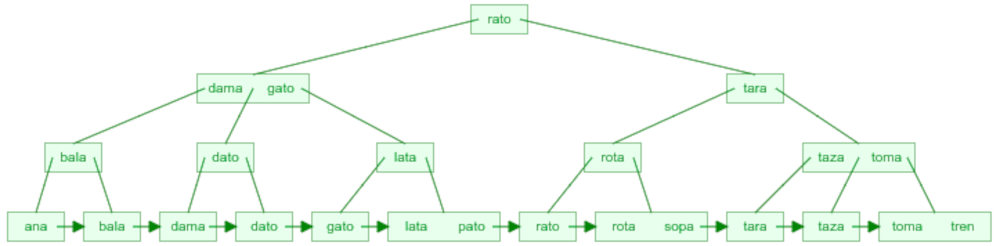
</p>

Arbol B+ de orden $M = 3$

Insertar `ana`

<p style="text-align: center;">
    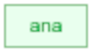
</p>

Insertar `bala`

<p style="text-align: center;">
    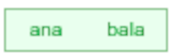
</p>

Insertar `dama`

<p style="text-align: center;">
    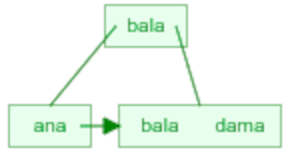
</p>

Insertar `dato`

<p style="text-align: center;">
    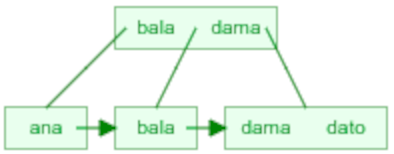
</p>

Insertar `gato`

<p style="text-align: center;">
    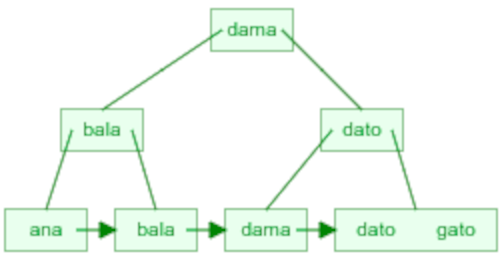
</p>

Insertar `lata`

<p style="text-align: center;">
    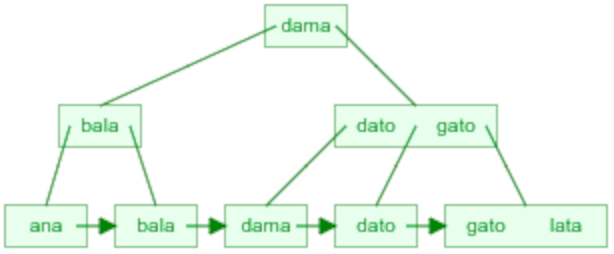
</p>

Insertar `pato`

<p style="text-align: center;">
    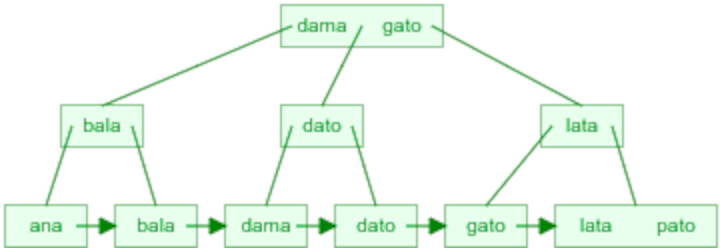
</p>

Insertar `rato`

<p style="text-align: center;">
    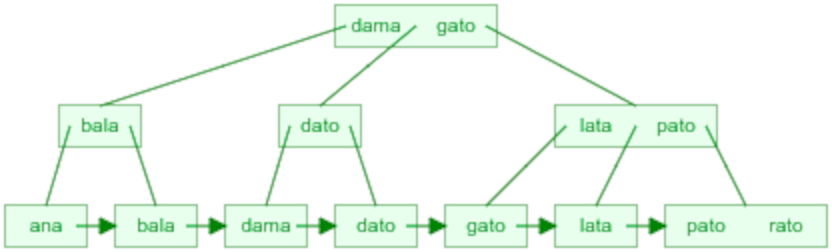
</p>

Insertar `rota`

<p style="text-align: center;">
    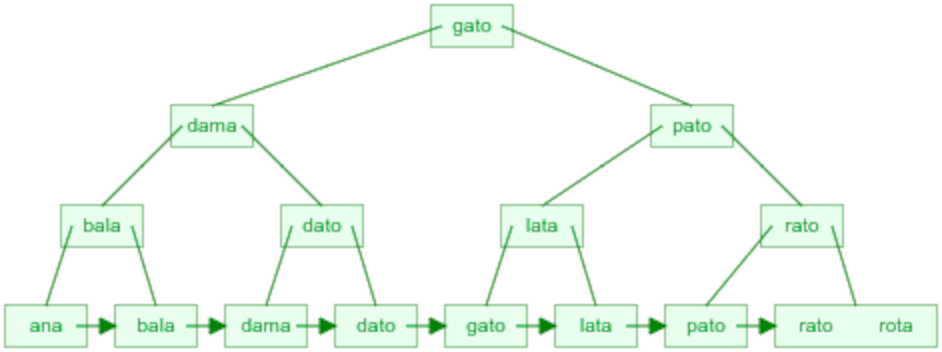
</p>

### Búsqueda con comodines

Buscar todo lo que empieza con `"da"` (buscar `da*`):

> Buscar todas las palabras p tales que `"da" <= palabra < "db"`

En este caso `{"dama", "dato"}`

Buscar todo lo que termina con `"ta"` (buscar `*ta`):

> Mantener además un árbol B de palabras al revés.
>
> Buscar todas las palabras p tales que `"at" <= p < "au"`

En este caso `{"atal", "ator"}` es decir `{"lata", "rota"}`

Una vez ubicadas las palabras, buscar los documentos asociados con cualquiera de esas palabras.

### Árbol B al revés

palabras al revés

```
ana  -> ana
bala -> alab
dama -> amad
dato -> otad
gato -> otag
lata -> atal
pato -> otap
rato -> otar
rota -> ator
```

<p style="text-align: center;">
    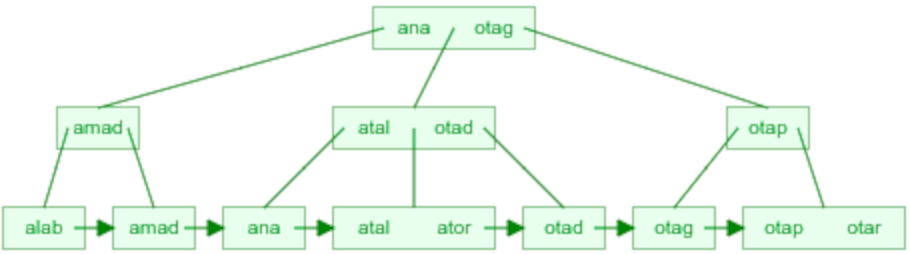
</p>

Buscar las palabras que empiezan `"r"` y terminan con `"o"` (`r*o`):

> Ubicar las palabras que cumplen con `r*`

En este caso `{"rato", "rota"}`

> Ubicar las palabras que cumplen con `*o`

En este caso `{"otad", "otag", "otap", "otar"}` es decir `{"dato", "gato", "pato", "rato"}`

> Intersecar los dos conjuntos de palabras.

`{"rato", "rota"} & {"dato", "gato", "pato", "rato"} = {"rato"}`

Es muy caro

### Árboles B en Python

In [ ]:
%pip install BTrees

In [ ]:
import string

from BTrees.OOBTree import OOBTree as BTree
from nltk.corpus import stopwords  # Stopwords
from nltk.stem import SnowballStemmer  # Stemmer


class IndiceInvertidoBTree:

    def __init__(self, documentos):
        """Recibe un diccionario con los documentos"""
        self.stop_words = frozenset(stopwords.words("spanish"))
        self._docs = documentos
        self._spanish_stemmer = SnowballStemmer("spanish", ignore_stopwords=False)
        self.__docs_to_docID()
        self.__generar_indice()

    def __docs_to_docID(self):
        """
        Asigna a cada documento un número y guarda dos diccionarios:
        el primero que tiene como clave el nombre del documento y como valor el
        numero de documento docID asociado y el segundo que permite realizar la
        operación inversa y tiene como clave los docID y como valor el nombre del
        documento
        """
        self._doc_to_docID = {doc: docID for docID, doc in enumerate(self._docs)}
        self._docID_to_doc = {docID: doc for doc, docID in self._doc_to_docID.items()}

    def __lematizar_palabra(self, palabra):
        """
        No vamos a usar el stemmer para no perder parte de la palabra y poder
        realizar búsquedas con comodines, en este caso más que lematizar la operación
        es acondicionar la palabra, pasando todo a mínuscula, eliminando acentos y signos
        de puntuación
        """
        palabra = palabra.lower().strip(string.punctuation + "»" + "\x97" + "¿" + "¡")

        reemplazos = {"á": "a", "é": "e", "ó": "o", "ú": "u", "í": "i"}
        palabra = "".join(reemplazos.get(c, c) for c in palabra)

        # palabra = self._spanish_stemmer.stem(palabra)

        return palabra

    def __generar_indice(self):
        """
        Genera los pares la lista de pares `(palabra, docID)` ordenada por palabra
        """
        pares = []
        for doc in self._docs:
            lista_palabras = [palabra for palabra in self._docs[doc].split() if not palabra in self.stop_words]
            lista_palabras = [self.__lematizar_palabra(palabra) for palabra in lista_palabras]
            pares = pares + [(palabra, self._doc_to_docID[doc]) for palabra in lista_palabras]

        # Cambiamos el diccionario de python por un diccionario sobre árboles B
        indice = BTree()

        for palabra, docID in pares:
            posting = indice.setdefault(palabra, set())
            posting.add(docID)

        self._indice = indice

    def __buscar(self, palabra):
        alfabeto = "abcdefghijklmnñopqrstuvwxyz"

        ultimo = palabra[-1]
        palabra_final = palabra[:-1] + alfabeto[(alfabeto.find(ultimo) + 1) % len(alfabeto)]
        palabras = set()
        claves = list(self._indice.keys())
        # minKey Devuelve la menor clave del árbol que sea mayor o igual a la palabra
        # que recibe como argumento
        menor = claves.index(self._indice.minKey(palabra))
        mayor = claves.index(self._indice.minKey(palabra_final))
        palabras = set(claves[menor:mayor])

        return palabras

    def buscar(self, palabra):
        """Búsqueda con comodines, solo soporta comodín al final de la palabra"""
        palabras = set()
        resultados = set()
        palabra_lematizada = self.__lematizar_palabra(palabra)

        if "*" not in palabra:  # palabra sin comodin
            if palabra_lematizada in self._indice:
                palabras.add(palabra_lematizada)
        elif palabra[-1] == "*":  # comodín al final
            palabras = self.__buscar(palabra[:-1])

        for pal in palabras:
            for docID in self._indice[pal]:
                resultados.add(self._docID_to_doc[docID])

        return palabras, resultados

In [ ]:
documentos = {
    "Introducción": "No sabemos cuándo empezó Tolkien a dirigir sus pensamientos al Reino Peligroso del País de las Hadas. Habían muchos perros en ese mundo para Roverandom. Egidio era un granjero y Niggle un soñador",
    "Roverandom": "Había una vez un perrito llamado Rover y su dueño Roverandom. El perro era muy pequeño y muy joven, pues de lo contrario se habría portado mejor; y era muy feliz jugando al sol en el jardín con una pelota amarilla, si nunca hubiera hecho lo que hizo. ",
    "Egidio": "Egidio el granjero tenía un perro. El nombre del perro era Garm. Los perros tenían que conformarse con nombres cortos en lengua vernácula; el latín culto quedaba reservado para sus dueños.",
    "Niggle": "Deberíamos salir al encuentro de centauros y dragones, y quizás así, de pronto, fijaríamos nuestra atención, como los pastores de antaño, en las ovejas, los perros, los caballos... y los lobos.",
}

ii = IndiceInvertidoBTree(documentos)

In [ ]:
for k, v in ii._indice.items():
    print(k, v)

In [ ]:
# Recuperación booleana
documentos = {"Introducción", "Roverandom", "Egidio", "Niggle"}

# "perro" and not "Roverandom"
_, contiene_perro = ii.buscar("perro")
_, contiene_roverandom = ii.buscar("Roverandom")

contiene_perro & (documentos - contiene_roverandom)

In [ ]:
# Búsqueda con comodín
palabras, resultados = ii.buscar("perr*")

print("palabras encontradas:", palabras)
print("Documentos donde se encuentran:", resultados)

## Bibliografía

Árboles B:

> Data Structures and Algorithms in Java, 3rd ed. by Mark Allen Weiss
Pearson Education, Inc., 2012
>
> [Wikipedia](https://es.wikipedia.org/wiki/%C3%81rbol_B%2B)
>
> [Visualizador online](https://www.cs.usfca.edu/~galles/visualization/BPlusTree.html)